# Champlin Smith - Predicting PC Video Game Success

In [14]:
import pandas as pd

file_path = f"C:\\Users\\champ\\OneDrive\\Documents\\MS Data Science\\DSC680 Applied Data Science\\DSC680\\bestSelling_games.csv"
df = pd.read_csv(file_path, encoding='ISO-8859-1')
df.head()

,game_name,reviews_like_rate,all_reviews_number,release_date,developer,user_defined_tags,supported_os,price,tags,age_restriction,rating,difficulty,length,estimated_downloads
0,Counter-Strike 2,86,8803754,"21 Aug, 2012",Valve,"FPS, Action, Tactical","win, linux",0.00,"Cross-Platform Multiplayer, Steam Trading Card...",17,3.20,4,80,306170000
1,PUBG: BATTLEGROUNDS,59,2554482,"21 Dec, 2017",PUBG Corporation,"Survival, Shooter, Action, Tactical",win,0.00,"Online PvP, Stats, Remote Play on Phone, Remot...",13,3.10,4,73,162350000
2,ELDEN RING NIGHTREIGN,77,53426,"30 May, 2025","FromSoftware, Inc.","Souls-like, Open World, Fantasy, RPG",win,25.99,"Single-player, Online Co-op, Steam Achievement...",17,3.96,4,50,840000
3,The Last of Usâ¢ Part I,79,45424,"28 Mar, 2023",Naughty Dog LLC,"Story Rich, Shooter, Survival, Horror",win,59.99,"Single-player, Steam Achievements, Steam Tradi...",17,4.10,3,24,2000000
4,Red Dead Redemption 2,92,672140,"5 Dec, 2019",Rockstar Games,"Open World, Story Rich, Adventure, Realistic, ...",win,59.99,"Single-player, Online PvP, Online Co-op, Steam...",17,4.32,3,80,21610000


Explode tags/categories and os fields, then transform them into booleans

In [15]:
import re

# Split tags strictly on commas
df['tags'] = df['tags'].fillna('').apply(lambda x: [tag.strip() for tag in x.split(',') if tag.strip()])

# Get top 10 most common raw tag strings
from collections import Counter
tag_counter = Counter(tag for tag_list in df['tags'] for tag in tag_list)
top_10_tags = [tag for tag, _ in tag_counter.most_common(15)]

# Function to make safe column names (without touching tag content logic)
def clean_column_name(tag):
    return 'tag_' + re.sub(r'\W+', '_', tag.strip().lower())

# Create flag columns only for top 10 tags
for tag in top_10_tags:
    col_name = clean_column_name(tag)
    df[col_name] = df['tags'].apply(lambda tag_list: tag in tag_list)

df = df.drop(columns=['tags', 'supported_os'])

output_path = "processed_games_dataset.csv"

In [16]:
print(df.columns.tolist())

['game_name', 'reviews_like_rate', 'all_reviews_number', 'release_date', 'developer', 'user_defined_tags', 'price', 'age_restriction', 'rating', 'difficulty', 'length', 'estimated_downloads', 'tag_single_player', 'tag_family_sharing', 'tag_steam_achievements', 'tag_steam_cloud', 'tag_steam_trading_cards', 'tag_online_co_op', 'tag_online_pvp', 'tag_steam_workshop', 'tag_steam_leaderboards', 'tag_in_app_purchases', 'tag_remote_play_on_tv', 'tag_remote_play_together', 'tag_cross_platform_multiplayer', 'tag_remote_play_on_tablet', 'tag_stats']


Explode user tags fields, then transform them into booleans

In [17]:
# Split user_defined_tags strictly on commas
df['user_defined_tags'] = df['user_defined_tags'].fillna('').apply(lambda x: [tag.strip() for tag in x.split(',') if tag.strip()])

# Get top 10 most common user_defined_tags
user_tag_counter = Counter(tag for tag_list in df['user_defined_tags'] for tag in tag_list)
top_10_user_tags = [tag for tag, _ in user_tag_counter.most_common(10)]

# Function to clean column names
def clean_column_name(tag):
    return 'user_tag_' + re.sub(r'\W+', '_', tag.strip().lower())

# Create flag columns for top 10 user_defined_tags
for tag in top_10_user_tags:
    col_name = clean_column_name(tag)
    df[col_name] = df['user_defined_tags'].apply(lambda tag_list: tag in tag_list)

# Drop the original user_defined_tags column
df = df.drop(columns=['user_defined_tags'])


Create feature to determine 'value' ie dollars per minute of game length

In [18]:
df['price_to_length'] = df.apply(
    lambda row: row['price'] / row['length'] if pd.notnull(row['price']) and pd.notnull(row['length']) and row['length'] != 0 else None,
    axis=1
)


Create new feature to determine ratio of users who downloaded the game vs reviewed it

In [19]:
df['reviews_to_downloads'] = df.apply(
    lambda row: row['all_reviews_number'] / row['estimated_downloads']
    if pd.notnull(row['all_reviews_number']) and pd.notnull(row['estimated_downloads']) and row['estimated_downloads'] != 0
    else None,
    axis=1
)

# EDA

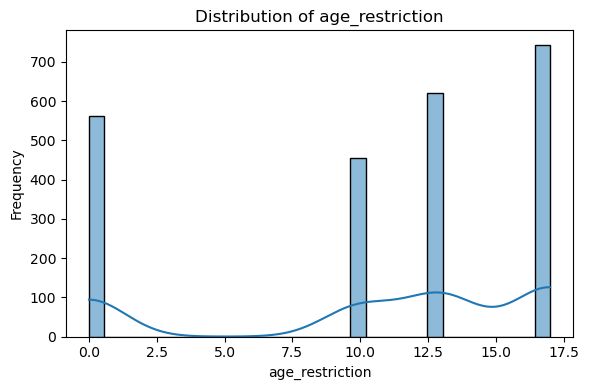

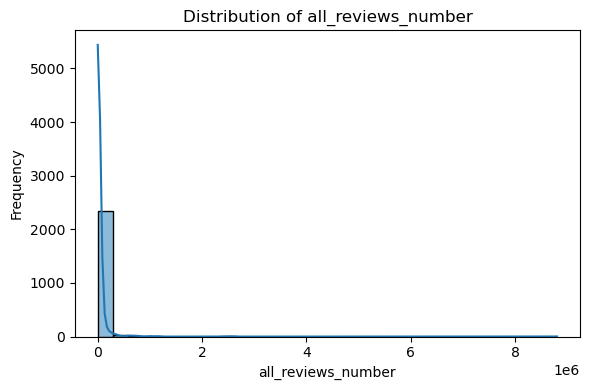

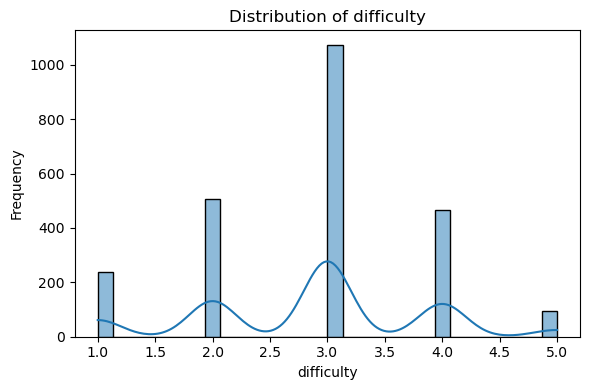

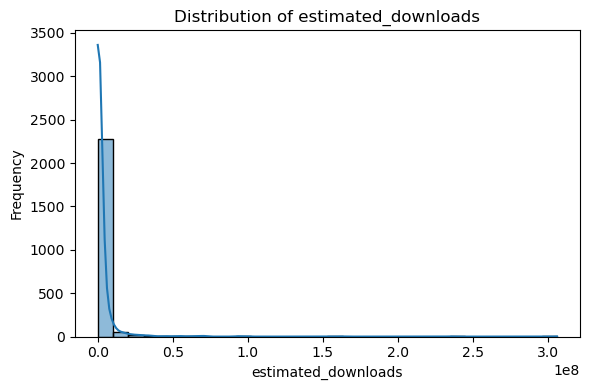

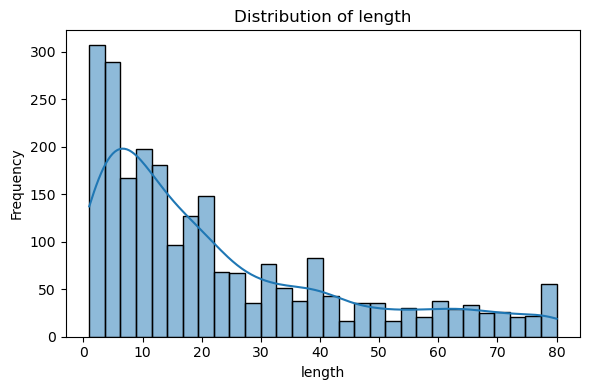

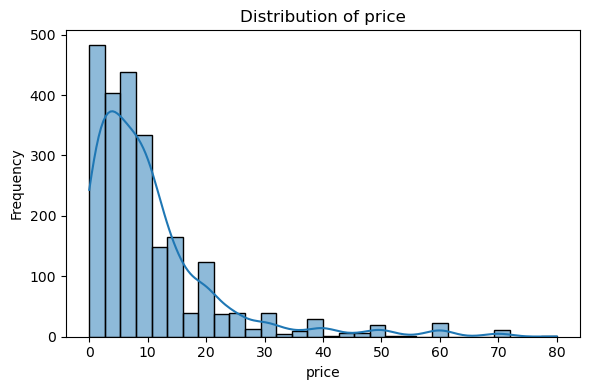

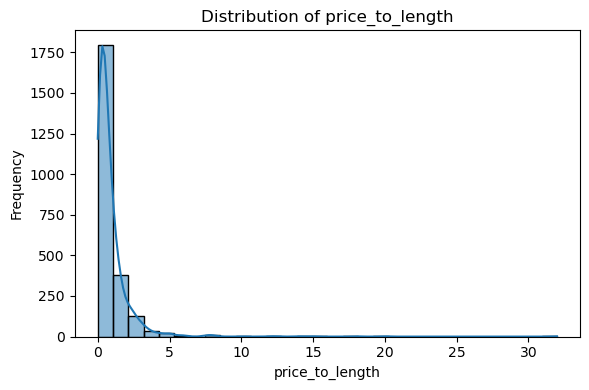

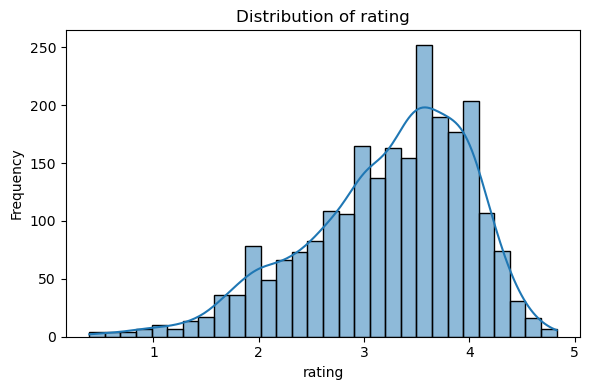

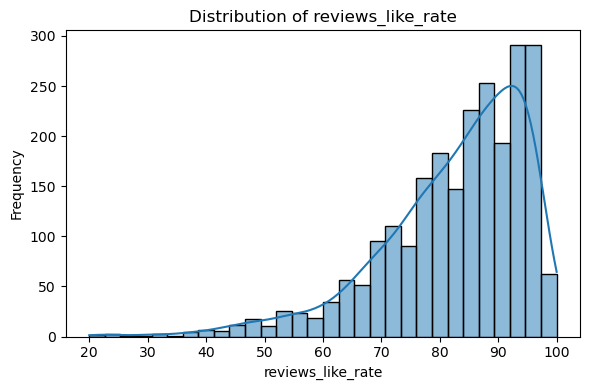

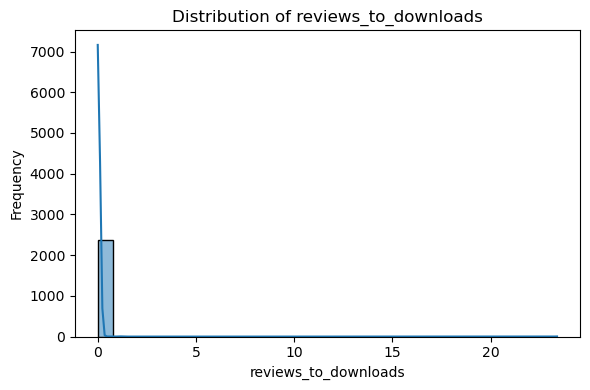

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Filter numeric columns, excluding 'game_name' and 'developer'
excluded_cols = ['game_name', 'developer']
numeric_cols = df.select_dtypes(include='number').columns.difference(excluded_cols)

# Plot distributions
for col in numeric_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col].dropna(), kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()


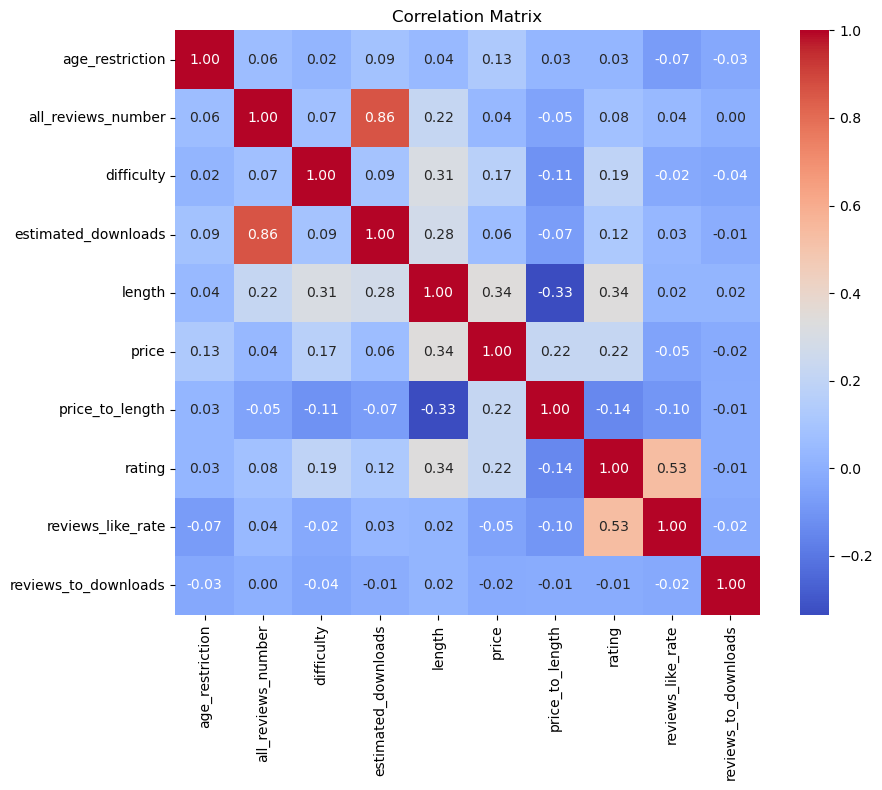

In [21]:
plt.figure(figsize=(10, 8))
corr_matrix = df[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()


# need to isolate data leakage ie estimated downloads and number of reviews data leak

In [22]:
df = df.drop(columns=['all_reviews_number'])

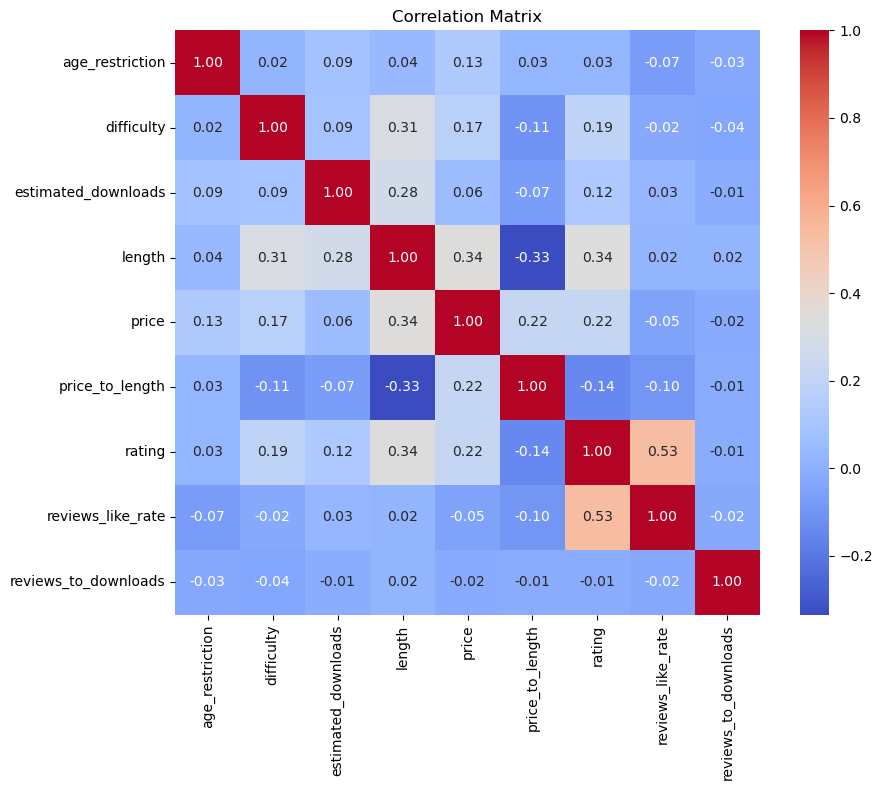

In [23]:
numeric_cols = df.select_dtypes(include='number').columns.difference(excluded_cols)
plt.figure(figsize=(10, 8))
corr_matrix = df[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()


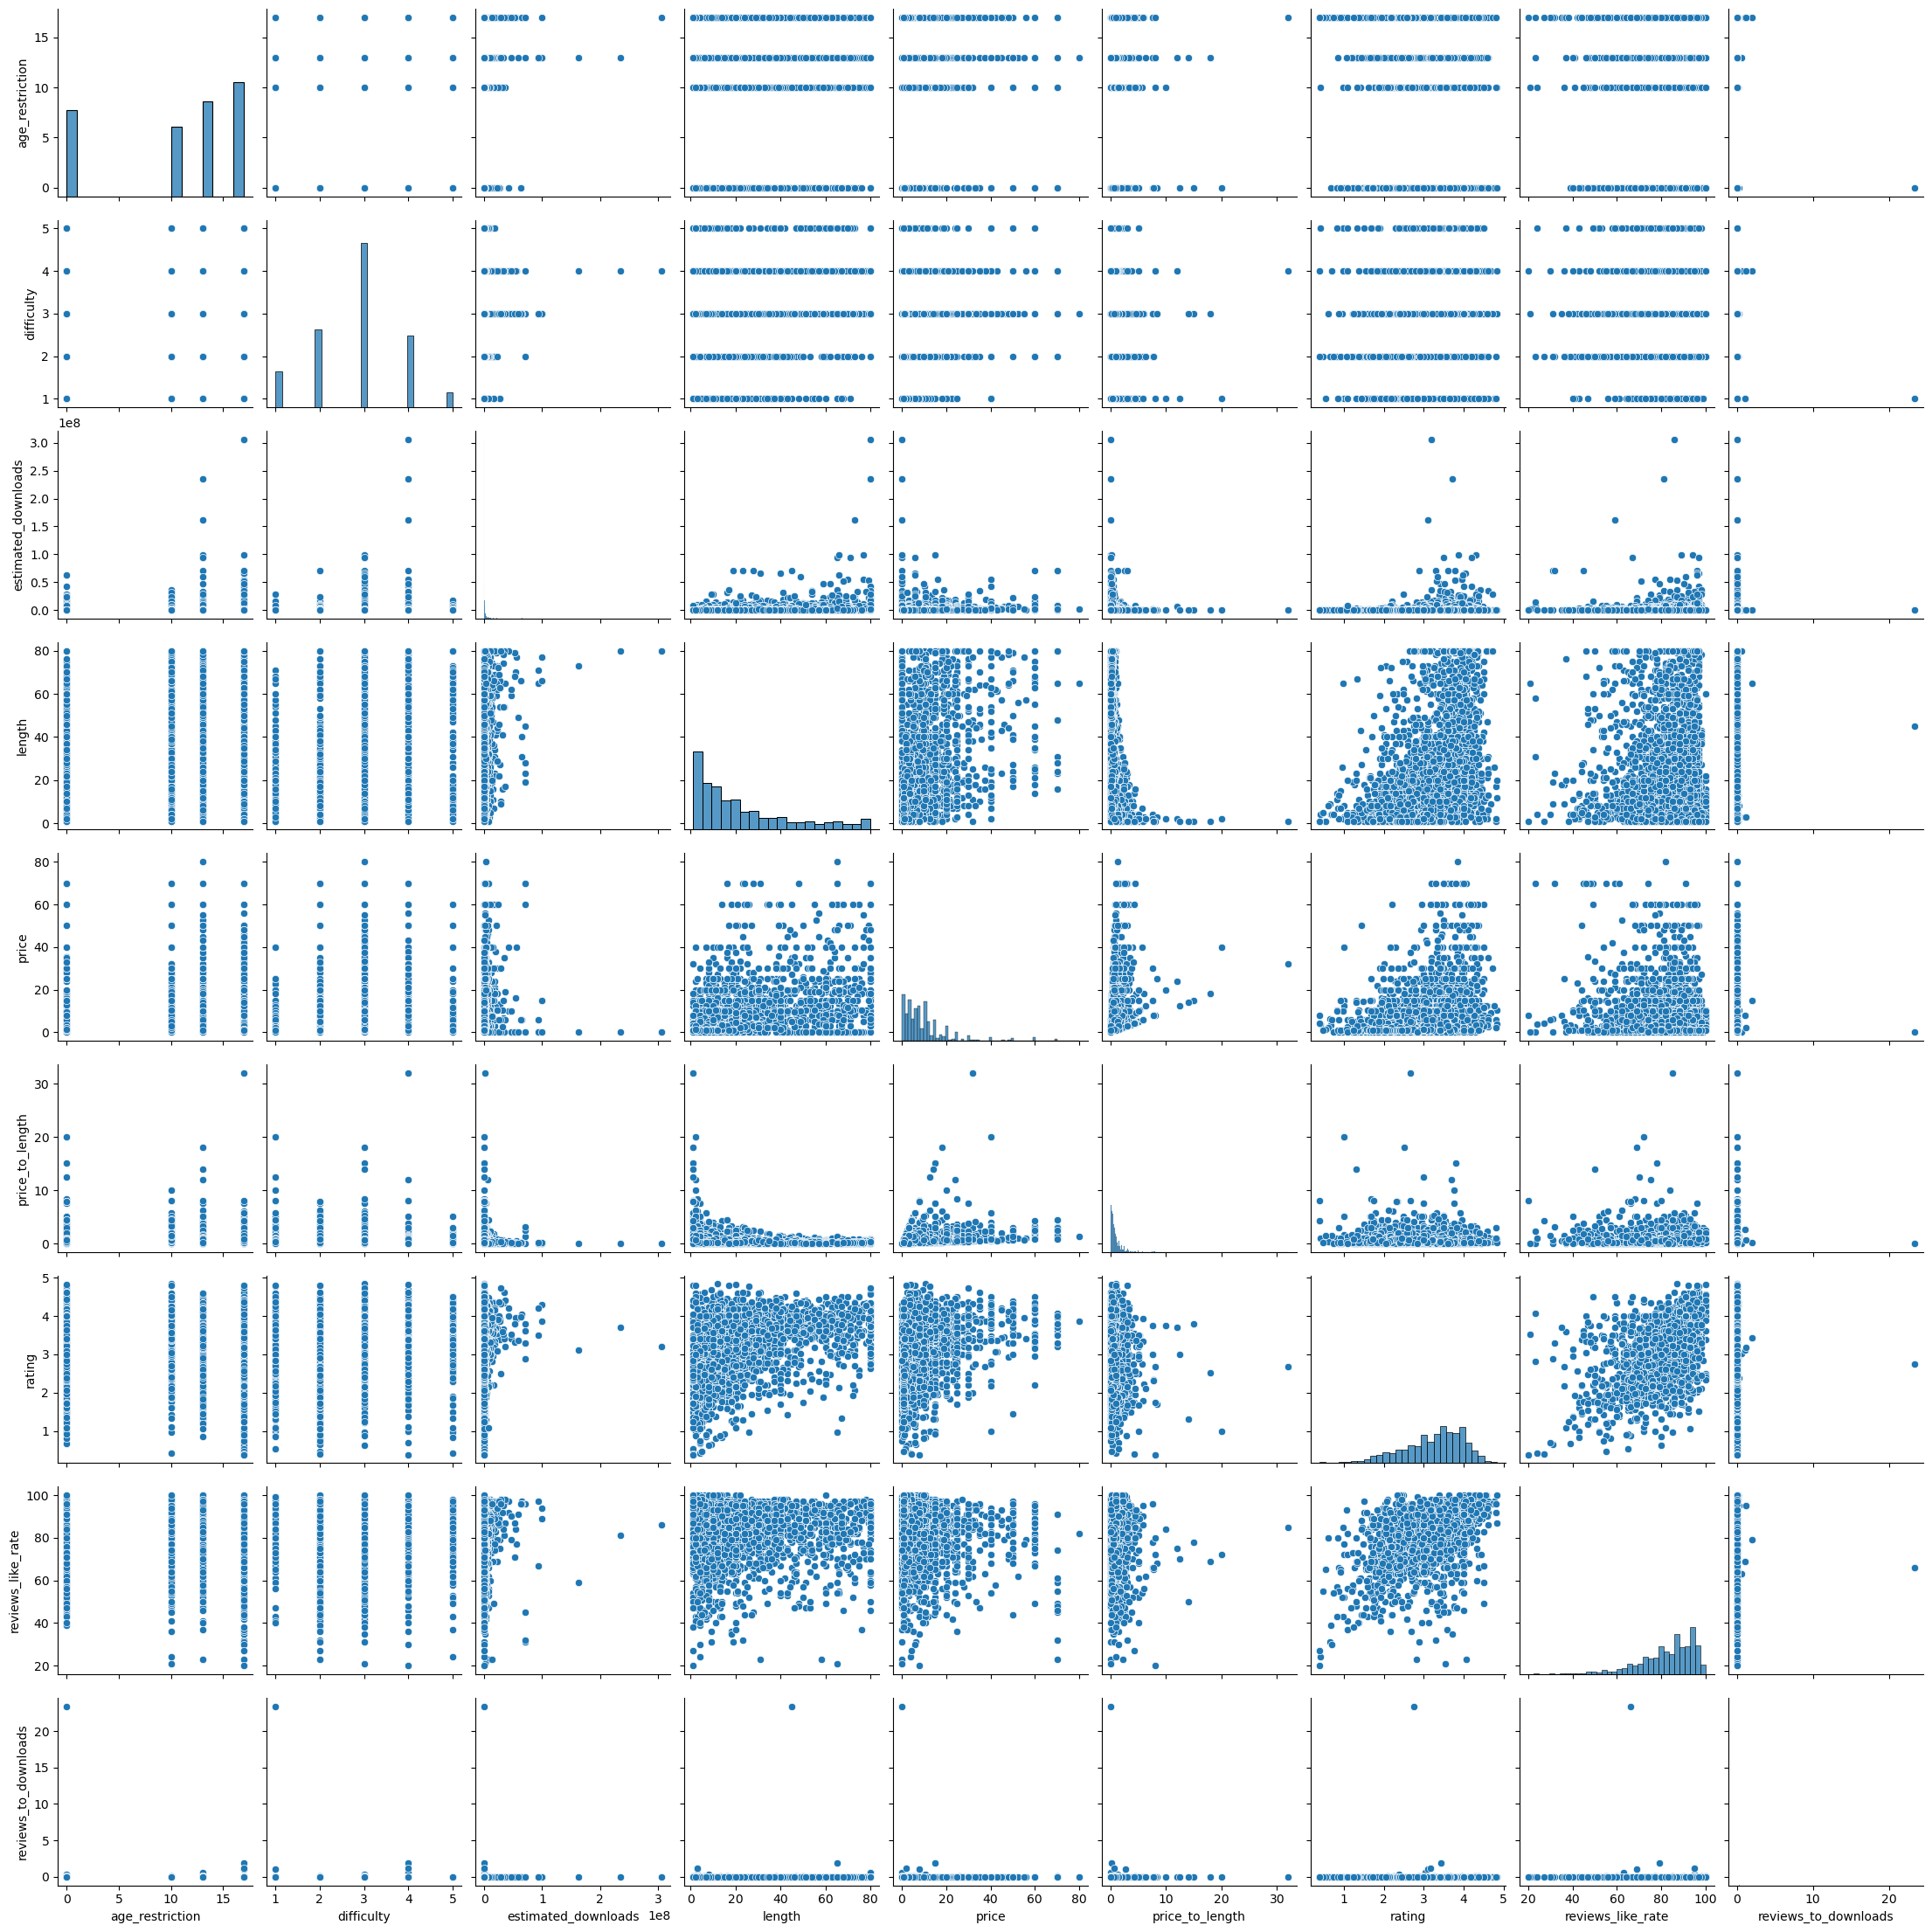

In [24]:
import seaborn as sns

# Select numeric columns and drop 'all_reviews_number' if still present
excluded_cols = ['game_name', 'developer', 'all_reviews_number']
numeric_cols = df.select_dtypes(include='number').columns.difference(excluded_cols)

# Create pair plot
sns.pairplot(df[numeric_cols])
plt.show()


# Intitial model build - before refinement

In [25]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from statsmodels.api import OLS, add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings("ignore")

# --- Drop non-feature columns ---
excluded_cols = ['game_name', 'developer']
df_model = df.drop(columns=excluded_cols)

# --- Convert release_date to release_year ---
df_model['release_year'] = pd.to_datetime(df_model['release_date'], errors='coerce').dt.year
df_model = df_model.drop(columns=['release_date'])

# --- Drop rows with missing target ---
df_model = df_model[df_model['estimated_downloads'].notnull()]

# --- Set target and drop it from features to prevent leakage ---
y = df_model['estimated_downloads']
df_model = df_model.drop(columns=['estimated_downloads'])

# --- Ensure all columns are numeric ---
df_model = df_model.copy()
for col in df_model.select_dtypes(include='bool').columns:
    df_model[col] = df_model[col].astype(int)
df_model = df_model.select_dtypes(include=[np.number])


# --- Drop remaining missing values ---
df_model = df_model.dropna()

# --- Define X and y ---
X = df_model
X_const = add_constant(X)

# --- VIF calculation ---
vif_data = pd.DataFrame()
vif_data["feature"] = X_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]

print("\nVIF Scores:")
print(vif_data)

# --- Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(X_const, y, test_size=0.2, random_state=42)

# --- Statsmodels OLS regression ---
model_sm = OLS(y_train, X_train).fit()
print("\nRegression Summary:")
print(model_sm.summary())

# --- Scikit-learn model for cross-validation ---
from sklearn.linear_model import LinearRegression
cv = KFold(n_splits=10, shuffle=True, random_state=42)
model_sk = LinearRegression()
cv_scores = cross_val_score(model_sk, X_const, y, cv=cv, scoring='r2')

print("\n10-Fold Cross-Validation R² Scores:")
print(cv_scores)
print(f"Mean R²: {np.mean(cv_scores):.4f}")



VIF Scores:
                           feature            VIF
0                            const  255060.601043
1                reviews_like_rate       1.759052
2                            price       1.620707
3                  age_restriction       1.415122
4                           rating       1.819984
5                       difficulty       1.238309
6                           length       2.137576
7                tag_single_player       1.449707
8               tag_family_sharing       2.101143
9           tag_steam_achievements       1.345202
10                 tag_steam_cloud       1.348457
11         tag_steam_trading_cards       1.336207
12                tag_online_co_op       1.431775
13                  tag_online_pvp       1.712182
14              tag_steam_workshop       1.177529
15          tag_steam_leaderboards       1.219456
16            tag_in_app_purchases       2.130214
17           tag_remote_play_on_tv       1.324667
18        tag_remote_play_together   

# Initial model not performant - switching to Random Forest Regression model

Performance metrics were not good - additionally, the target feature has a heavy tail, necessitating the need for major transformations or model change, and model change was chosen.

10-Fold Cross-Validation R² Scores:
[0.63827757 0.65831009 0.59827312 0.66179658 0.66823692 0.62841587
 0.65635735 0.64951026 0.6705761  0.6124056 ]
Mean R²: 0.6442

10-Fold Cross-Validation MAE Scores:
[1.24112816 1.17864902 1.14584341 1.22343046 1.12199509 1.18079355
 1.16567333 1.08402651 1.12600496 1.24118838]
Mean MAE: 1.1709

Test Set Performance (original scale):
R²: 0.2144
MAE: 1624052.04
RMSE: 5762842.10


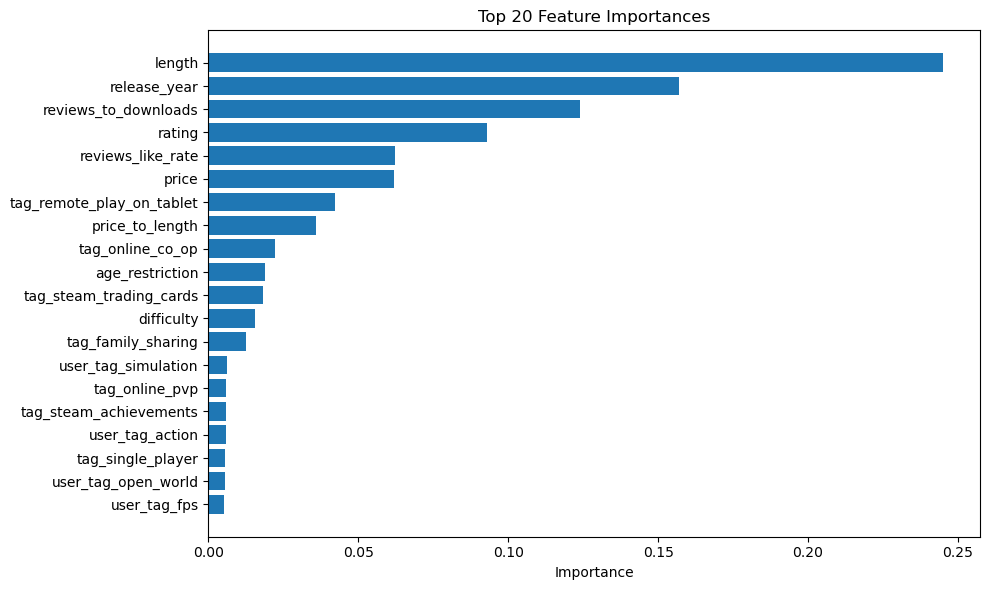

In [26]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# --- Prepare data (same as before) ---
excluded_cols = ['game_name', 'developer']
df_model = df.drop(columns=excluded_cols)

df_model['release_year'] = pd.to_datetime(df_model['release_date'], errors='coerce').dt.year
df_model = df_model.drop(columns=['release_date'])

# Drop rows with missing target or features
df_model = df_model[df_model['estimated_downloads'].notnull()]
df_model = df_model.dropna()

# Target and features
y = df_model['estimated_downloads']
X = df_model.drop(columns=['estimated_downloads'])

# Convert bool columns to int
for col in X.select_dtypes(include='bool').columns:
    X[col] = X[col].astype(int)

# Log-transform target
y_log = np.log1p(y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)

# Initialize model
rf = RandomForestRegressor(random_state=42, n_jobs=-1, n_estimators=100)

# Cross-validation setup
cv = KFold(n_splits=10, shuffle=True, random_state=42)

# Cross-val R^2
cv_r2 = cross_val_score(rf, X_train, y_train, cv=cv, scoring='r2')

# Cross-val MAE (negated by default, so negate back)
cv_mae = cross_val_score(rf, X_train, y_train, cv=cv, scoring='neg_mean_absolute_error')
cv_mae = -cv_mae

print("10-Fold Cross-Validation R² Scores:")
print(cv_r2)
print(f"Mean R²: {np.mean(cv_r2):.4f}")

print("\n10-Fold Cross-Validation MAE Scores:")
print(cv_mae)
print(f"Mean MAE: {np.mean(cv_mae):.4f}")

# Fit on full training set
rf.fit(X_train, y_train)

# Predict on test set
y_pred_log = rf.predict(X_test)
y_pred = np.expm1(y_pred_log)  # invert log1p transform
y_test_orig = np.expm1(y_test)

# Metrics on test set (original scale)
r2 = r2_score(y_test_orig, y_pred)
mae = mean_absolute_error(y_test_orig, y_pred)
rmse = mean_squared_error(y_test_orig, y_pred, squared=False)

print("\nTest Set Performance (original scale):")
print(f"R²: {r2:.4f}")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

# Feature importances plot
importances = rf.feature_importances_
feat_names = X.columns

feat_imp_df = pd.DataFrame({'feature': feat_names, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='importance', ascending=False).head(20)

plt.figure(figsize=(10, 6))
plt.barh(feat_imp_df['feature'][::-1], feat_imp_df['importance'][::-1])
plt.title("Top 20 Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()
